In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import data_processing as dp
import warnings
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.neighbors import KNeighborsClassifier


warnings.filterwarnings("ignore")

data = arff.loadarff("../../data/3year.arff")
df = pd.DataFrame(data[0])
df_origin = df.copy()

In [78]:
X_smote, X_test, y_smote, y_test = dp.pre_process(df)

In [79]:
# The fundamental KNN prediction
def KNN(X_train, X_test, y_train, y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    accuracy_k = accuracy_score(y_test, y_pred)
    precision_k = precision_score(y_test, y_pred)
    recall_k = recall_score(y_test, y_pred)
    f1_k = f1_score(y_test, y_pred)
    confusion_mat_k = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy_k}")
    print(f"precision = {precision_k}")
    print(f"recall = {recall_k}")
    print(f"f1 = {f1_k}")
    print(f"confusion matrix = {confusion_mat_k}")
    print(classification_rep)

In [80]:
for k in range(2, 20):
    print(k)
    KNN(X_smote, X_test, y_smote, y_test, k)
    print("\n")


# we can see the accuracy dropped significantly beyond k=10 so we fix k<10 in the following sections

2
Accuracy = 0.8549666772453189
precision = 0.06702412868632708
recall = 0.1865671641791045
f1 = 0.09861932938856016
confusion matrix = [[2669  348]
 [ 109   25]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      3017
           1       0.07      0.19      0.10       134

    accuracy                           0.85      3151
   macro avg       0.51      0.54      0.51      3151
weighted avg       0.92      0.85      0.89      3151



3
Accuracy = 0.7749920660107902
precision = 0.05564142194744977
recall = 0.26865671641791045
f1 = 0.09218950064020487
confusion matrix = [[2406  611]
 [  98   36]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      3017
           1       0.06      0.27      0.09       134

    accuracy                           0.77      3151
   macro avg       0.51      0.53      0.48      3151
weighted avg       0.92      0.77      0.84      3151



4
Accuracy = 0.

In [3]:
##1. anova
def KNN_anova(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)

    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    return train_accuracy, test_accuracy

Best k for train_accuracy: 30
Best k for test_accuracy: 27


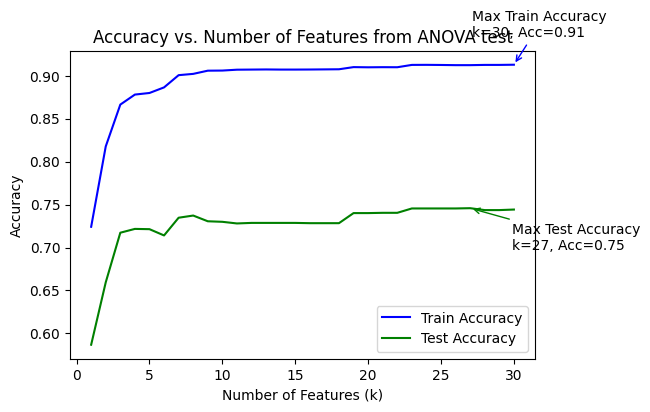

(         Attr29    Attr63    Attr24    Attr48    Attr33    Attr55    Attr36  \
 0      0.396077  0.000687  0.252086  0.270426  0.001175  0.181335  0.009412   
 1      0.459574  0.001888  0.255907  0.278044  0.001680  0.182337  0.011841   
 2      0.350609  0.002803  0.253041  0.271485  0.002629  0.181959  0.021547   
 3      0.327540  0.001921  0.252756  0.271702  0.002002  0.181901  0.011452   
 4      0.361823  0.001758  0.253098  0.272009  0.001889  0.181968  0.014372   
 ...         ...       ...       ...       ...       ...       ...       ...   
 13973  0.347861  0.002940  0.253059  0.272586  0.002678  0.181925  0.018222   
 13974  0.442719  0.001591  0.253012  0.272608  0.001815  0.182257  0.014159   
 13975  0.428601  0.002894  0.252952  0.271522  0.002710  0.181303  0.024621   
 13976  0.372259  0.006413  0.253878  0.275663  0.005097  0.182085  0.041716   
 13977  0.533448  0.001928  0.255565  0.272894  0.001527  0.191575  0.004738   
 
          Attr51    Attr61    Attr59  

In [ ]:
dp.find_best_k_features_from_ANOVA(KNN_anova, X_smote, X_test, y_smote, y_test)

In [57]:
##2. use bagging to decrease variance
from sklearn.ensemble import BaggingClassifier


def KNN_bagging(X_train, X_test, y_train, y_test, k, n):
    knn = KNeighborsClassifier(n_neighbors=k)

    # Initialize the Bagging classifier with k-NN as the base estimator
    bagging_knn = BaggingClassifier(knn, n_estimators=n, random_state=42)

    bagging_knn.fit(X_train, y_train)

    y_pred = bagging_knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return pd.Series(
        {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    )


KNN_bagging(X_smote, X_test, y_smote, y_test, 2, 10)
# This technique has caused lower accuracy and precision despite the improvement in recall.

accuracy     0.799111
precision    0.058407
recall       0.246269
f1           0.094421
dtype: float64

In [102]:
# 3. K-fold cross validation
from sklearn.model_selection import cross_val_score

X = pd.concat([X_smote, X_test])
y = pd.concat([y_smote, y_test])


def knn_k_fold(X, y, k_neighbor, k):
    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)

    # Perform k-fold cross-validation
    k_fold = k

    # Train a new model using the entire dataset
    final_model = KNeighborsClassifier(n_neighbors=k_neighbor)
    final_model.fit(X, y)

    X_test = X.iloc[13978:, :]

    y_pred_kfold = final_model.predict(X_test)
    accuracy_k_fold = accuracy_score(y_test, y_pred_kfold)
    precision_k_fold = precision_score(y_test, y_pred_kfold)
    recall_k_fold = recall_score(y_test, y_pred_kfold)
    f1_k_fold = f1_score(y_test, y_pred_kfold)
    classification_rep = classification_report(y_test, y_pred_kfold)
    print(f"Accuracy = {accuracy_k_fold}")
    print(f"precision = {precision_k_fold}")
    print(f"recall = {recall_k_fold}")
    print(f"f1 = {f1_k_fold}")
    print(classification_rep)


def get_k_fold_model(X, y, k_neighbor, k):
    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)

    # Perform k-fold cross-validation
    k_fold = k

    # Train a new model using the entire dataset
    final_model = KNeighborsClassifier(n_neighbors=k_neighbor)
    final_model.fit(X, y)

    return final_model

In [82]:
knn_k_fold(X, y, 2, 10)
# The precision is one indicating the false positive is zero. We will consider increasing k

Accuracy = 0.9657251666137734
precision = 1.0
recall = 0.19402985074626866
f1 = 0.325
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3017
           1       1.00      0.19      0.33       134

    accuracy                           0.97      3151
   macro avg       0.98      0.60      0.65      3151
weighted avg       0.97      0.97      0.95      3151



In [ ]:
knn_k_fold(X, y, 5, 10)
# this technique had improved all of the evaluation metrices of the model

In [83]:
# 4. Grid Search
from sklearn.model_selection import GridSearchCV


def optimize_k_neighbors(X, y, k_neighbors):
    # Define the parameter grid
    param_grid = {"n_neighbors": k_neighbors}

    # Initialize the KNN classifier
    knn = KNeighborsClassifier()

    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring="f1")

    # Fit the grid search to the data
    grid_search.fit(X, y)

    # Get the best estimator and best score
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    return best_estimator, best_score, best_params


# Define the range of k_neighbors values to try
k_neighbors = range(1, 21)

# Optimize k_neighbors
best_knn_model, best_f1_score, best_params = optimize_k_neighbors(X, y, k_neighbors)

print("Best k_neighbors:", best_params["n_neighbors"])
print("Best F1 score:", best_f1_score)
y_pred_kfold_k = best_knn_model.predict(X_test)

accuracy_gs_k = accuracy_score(y_test, y_pred_kfold_k)
precision_gs_k = precision_score(y_test, y_pred_kfold_k)
recall_gs_k = recall_score(y_test, y_pred_kfold_k)
f1_gs_k = f1_score(y_test, y_pred_kfold_k)
confusion_mat_gs_k = confusion_matrix(y_test, y_pred_kfold_k)
classification_rep = classification_report(y_test, y_pred_kfold_k)


print(f"Accuracy = {accuracy_gs_k}")
print(f"precision = {precision_gs_k}")
print(f"recall = {recall_gs_k}")
print(f"f1 = {f1_gs_k}")
print(f"confusion matrix = {confusion_mat_gs_k}")
print(classification_rep)
# this technique returned a model with k=2 and thus caused perfect precision again

Best k_neighbors: 2
Best F1 score: 0.8944316077621377
Accuracy = 0.9657251666137734
precision = 1.0
recall = 0.19402985074626866
f1 = 0.325
confusion matrix = [[3017    0]
 [ 108   26]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3017
           1       1.00      0.19      0.33       134

    accuracy                           0.97      3151
   macro avg       0.98      0.60      0.65      3151
weighted avg       0.97      0.97      0.95      3151



In [62]:
# 5. PCA
# we are trying to reduce the curse of dimensionality
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix


def pca(X_train, X_test, y_train, y_test, n):
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    # Standardize the feature matrix
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA with desired number of components
    pca = PCA(n_components=n)

    # Apply PCA to the standardized feature matrix
    X_pca = pca.fit_transform(X_scaled)
    columns = [f"PC{i+1}" for i in range(n)]  # Column names for components
    X_pca_df = pd.DataFrame(X_pca, columns=columns)
    X_smote_pca = X_pca_df.iloc[:13978, :]
    X_test_pca = X_pca_df.iloc[13978:, :]
    return X_smote_pca, X_test_pca


# Now X_pca contains the reduced-dimensional dataset with n_components features

In [64]:
def KNN_pca(X_train, X_test, y_train, y_test, k, n):
    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, n)

    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return pd.Series(
        {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    )


KNN_pca(X_smote, X_test, y_smote, y_test, 5, 3)

accuracy     0.675341
precision    0.059465
recall       0.447761
f1           0.104987
dtype: float64

In [66]:
# we are trying to find the best n for each k to maximize the metric scores
def find_optimal_n_pca(metric, a, b, k):  # k is k-neighbors
    max_n = 0
    max_met = 0
    for n in range(a, b):
        curr_met = KNN_pca(X_train, X_test, y_smote, y_test, k, n)[metric]
        if curr_met > max_met:
            max_met = curr_met
            max_n = n
    return max_n, max_met


# list n that maximize model performance at each k
def list_pca():
    for metric in ["accuracy", "precision", "recall", "f1"]:
        print(metric)
        for k in range(1, 11):
            max_n, max_met = find_optimal_n_pca(metric, 1, 30, k)
            print(f"k={k} : {max_n}, {max_met}")
        print("\n")


list_pca()

accuracy
k=1 : 23, 0.8365598222786417
k=2 : 23, 0.8698825769596953
k=3 : 26, 0.7930815614090765
k=4 : 29, 0.8225960012694383
k=5 : 24, 0.7635671215487146
k=6 : 26, 0.7892732465883846
k=7 : 27, 0.7432561091716915
k=8 : 18, 0.7670580768010156
k=9 : 25, 0.7245318946366233
k=10 : 15, 0.7483338622659473


precision
k=1 : 19, 0.09018036072144289
k=2 : 19, 0.1
k=3 : 19, 0.08160237388724036
k=4 : 19, 0.08944543828264759
k=5 : 20, 0.07372654155495978
k=6 : 18, 0.08074534161490683
k=7 : 18, 0.07506053268765134
k=8 : 18, 0.07865168539325842
k=9 : 23, 0.07217694994179279
k=10 : 17, 0.07741116751269035


recall
k=1 : 1, 0.5746268656716418
k=2 : 2, 0.3358208955223881
k=3 : 1, 0.5522388059701493
k=4 : 19, 0.373134328358209
k=5 : 3, 0.5447761194029851
k=6 : 2, 0.44776119402985076
k=7 : 2, 0.5149253731343284
k=8 : 2, 0.4626865671641791
k=9 : 4, 0.5373134328358209
k=10 : 4, 0.47761194029850745


f1
k=1 : 19, 0.14218009478672985
k=2 : 19, 0.14682539682539683
k=3 : 19, 0.13613861386138615
k=4 : 19, 0.1443

In [16]:
# pca first then predict

"""
def plot_pca_predict_3d(X_train, X_test, y_train, y_test, k):

    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    knn.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_pca)

    # Visualize the reduced-dimensional data in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        X_test_pca.iloc[:, 0],
        X_test_pca.iloc[:, 1],
        X_test_pca.iloc[:, 2],
        c=y_pred,
        cmap=plt.cm.Set1,
        edgecolor="k",
    )
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("PCA Visualization(3D)")
    plt.show()
    """

In [17]:
"""
def plot_predict_pca_3d(X_train, X_test, y_train, y_test, k):

    knn = KNeighborsClassifier(n_neighbors=k)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Visualize the reduced-dimensional data in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        X_test_pca.iloc[:, 0],
        X_test_pca.iloc[:, 1],
        X_test_pca.iloc[:, 2],
        c=y_pred,
        cmap=plt.cm.Set1,
        edgecolor="k",
    )
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title("PCA Visualization(3D)")
    plt.show()
    """

In [ ]:
pip install plotly

In [128]:
# Visulization of the results
import plotly.graph_objs as go
from sklearn.decomposition import PCA


# do the prediction using original data with 30 features and use PCA to visualise the result
def plot_predict_pca_3d(X_train, X_test, y_train, y_test, k, model=None):

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    if model is None:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
    print(f"confusion matrix = ")
    print(confusion_mat)
    print(classification_rep)

    trace = go.Scatter3d(
        x=X_test_pca.iloc[:, 0],
        y=X_test_pca.iloc[:, 1],
        z=X_test_pca.iloc[:, 2],
        mode="markers",
        marker=dict(color=y_pred, size=3),  # Use predictions as colors
    )

    # Create layout for the plot
    layout = go.Layout(
        title="PCA Visualization (3D) - Predictions",
        scene=dict(
            xaxis=dict(title="PC1"),
            yaxis=dict(title="PC2"),
            zaxis=dict(title="PC3"),
        ),
    )

    # Create figure and add trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the interactive plot
    fig.show()

In [129]:
plot_predict_pca_3d(X_smote, X_test, y_smote, y_test, 5)

Accuracy = 0.7442081878768645
precision = 0.054376657824933686
recall = 0.30597014925373134
f1 = 0.09234234234234234
confusion matrix = 
[[2304  713]
 [  93   41]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3017
           1       0.05      0.31      0.09       134

    accuracy                           0.74      3151
   macro avg       0.51      0.53      0.47      3151
weighted avg       0.92      0.74      0.82      3151



In [124]:
# carry out PCA to reduce dimension to 3 and then do prediction using these data
def plot_pca_predict_3d(X_train, X_test, y_train, y_test, k, model=None):

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    if model is None:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
    print(f"confusion matrix = ")
    print(confusion_mat)
    print(classification_rep)

    trace = go.Scatter3d(
        x=X_test_pca.iloc[:, 0],
        y=X_test_pca.iloc[:, 1],
        z=X_test_pca.iloc[:, 2],
        mode="markers",
        marker=dict(color=y_pred, size=3),  # Use predictions as colors
    )

    # Create layout for the plot
    layout = go.Layout(
        title="PCA Visualization (3D) - Predictions",
        scene=dict(
            xaxis=dict(title="PC1"),
            yaxis=dict(title="PC2"),
            zaxis=dict(title="PC3"),
        ),
    )

    # Create figure and add trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the interactive plot
    fig.show()

In [125]:
plot_pca_predict_3d(X_smote, X_test, y_smote, y_test, 5)

Accuracy = 0.6683592510314186
precision = 0.057337220602526724
recall = 0.44029850746268656
f1 = 0.10146173688736028
confusion matrix = 
[[2047  970]
 [  75   59]]
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      3017
           1       0.06      0.44      0.10       134

    accuracy                           0.67      3151
   macro avg       0.51      0.56      0.45      3151
weighted avg       0.93      0.67      0.77      3151



In [113]:
# use all data in training and testing but remove outliers when doing visualization
def plot_pca_predict_3d_remove_outlier(
    X_train, X_test, y_train, y_test, k, t, model=None
):  # the visualization will excludes points that are t time away from mean

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    if model is None:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_pca, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_pca)

    z_scores = np.abs((X_test_pca - X_test_pca.mean()) / X_test_pca.std())

    # Define a threshold for Z-score (e.g., 3)
    threshold = t

    # Find indices of outliers where Z-score is greater than the threshold
    outlier_indices = np.where(z_scores > threshold)

    remove_indices = list(set(outlier_indices[0]))
    remove_indices.sort()

    X_test_pca = X_test_pca.reset_index(drop=True)

    # Remove outliers from the PCA-transformed test data and corresponding labels
    X_test_pca_filtered = X_test_pca.drop(remove_indices)
    y_pred_filtered = np.delete(y_pred, remove_indices)

    print(f"original number of points {(X_test_pca.shape[0])}")
    print(f"current number of points {(X_test_pca_filtered.shape[0])}")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
    print(f"confusion matrix = ")
    print(confusion_mat)
    print(classification_rep)

    trace = go.Scatter3d(
        x=X_test_pca_filtered.iloc[:, 0],
        y=X_test_pca_filtered.iloc[:, 1],
        z=X_test_pca_filtered.iloc[:, 2],
        mode="markers",
        marker=dict(color=y_pred_filtered, size=3),  # Use predictions as colors
    )

    # Create layout for the plot
    layout = go.Layout(
        title="PCA Visualization (3D) - Predictions",
        scene=dict(
            xaxis=dict(title="PC1"),
            yaxis=dict(title="PC2"),
            zaxis=dict(title="PC3"),
        ),
    )

    # Create figure and add trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the interactive plot
    fig.show()

In [114]:
plot_pca_predict_3d_remove_outlier(X_smote, X_test, y_smote, y_test, 7, 3)

original number of points 3151
current number of points 3120
Accuracy = 0.6699460488733735
precision = 0.06692160611854685
recall = 0.5223880597014925
f1 = 0.11864406779661017
confusion matrix = 
[[2041  976]
 [  64   70]]
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      3017
           1       0.07      0.52      0.12       134

    accuracy                           0.67      3151
   macro avg       0.52      0.60      0.46      3151
weighted avg       0.93      0.67      0.77      3151



In [130]:
# use all data in training and testing but remove outliers when doing visualization
def plot_predict_pca_3d_remove_outlier(
    X_train, X_test, y_train, y_test, k, t, model=None
):

    if model is None:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)

    X_train_pca, X_test_pca = pca(X_train, X_test, y_train, y_test, 3)

    # Predict on the test set
    y_pred = model.predict(X_test)

    z_scores = np.abs((X_test_pca - X_test_pca.mean()) / X_test_pca.std())

    # Define a threshold for Z-score (e.g., 3)
    threshold = t

    # Find indices of outliers where Z-score is greater than the threshold
    outlier_indices = np.where(z_scores > threshold)

    remove_indices = list(set(outlier_indices[0]))
    remove_indices.sort()
    print((remove_indices))

    X_test_pca = X_test_pca.reset_index(drop=True)

    # Remove outliers from the PCA-transformed test data and corresponding labels
    X_test_pca_filtered = X_test_pca.drop(remove_indices)
    y_pred_filtered = np.delete(y_pred, remove_indices)

    print(f"original number of points {(X_test_pca.shape[0])}")
    print(f"current number of points {(X_test_pca_filtered.shape[0])}")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
    print(f"confusion matrix = ")
    print(confusion_mat)
    print(classification_rep)

    trace = go.Scatter3d(
        x=X_test_pca_filtered.iloc[:, 0],
        y=X_test_pca_filtered.iloc[:, 1],
        z=X_test_pca_filtered.iloc[:, 2],
        mode="markers",
        marker=dict(color=y_pred_filtered, size=3),  # Use predictions as colors
    )

    # Create layout for the plot
    layout = go.Layout(
        title="PCA Visualization (3D) - Predictions",
        scene=dict(
            xaxis=dict(title="PC1"),
            yaxis=dict(title="PC2"),
            zaxis=dict(title="PC3"),
        ),
    )

    # Create figure and add trace
    fig = go.Figure(data=[trace], layout=layout)

    # Show the interactive plot
    fig.show()

In [131]:
plot_predict_pca_3d_remove_outlier(X_smote, X_test, y_smote, y_test, 5, 3)

[297, 346, 407, 580, 625, 701, 1009, 1030, 1091, 1112, 1168, 1310, 1476, 1504, 1528, 1581, 1641, 1707, 1813, 1891, 1963, 2382, 2517, 2548, 2588, 2607, 2692, 2742, 2783, 2807, 2852, 2950, 2968]
original number of points 3151
current number of points 3118
Accuracy = 0.7442081878768645
precision = 0.054376657824933686
recall = 0.30597014925373134
f1 = 0.09234234234234234
confusion matrix = 
[[2304  713]
 [  93   41]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3017
           1       0.05      0.31      0.09       134

    accuracy                           0.74      3151
   macro avg       0.51      0.53      0.47      3151
weighted avg       0.92      0.74      0.82      3151



In [132]:
# we choose suitable k an n from the list_pca just now to carry prediction and use k-fold cross validation to improve the model
X_train_pca19, X_test_pca19 = pca(X_smote, X_test, y_smote, y_test, 19)
X_pca = pd.concat([X_train_pca19, X_test_pca19])
kfold_model = get_k_fold_model(X_pca, y, 4, 10)

plot_predict_pca_3d_remove_outlier(
    X_train_pca19, X_test_pca19, y_smote, y_test, 4, 3, kfold_model
)

[625, 701, 859, 877, 1030, 1091, 1414, 1504, 1587, 1707, 1891, 1963, 2154, 2157, 2382, 2519, 2534, 2607, 2717, 2783, 2807, 2852]
original number of points 3151
current number of points 3129
Accuracy = 0.9086004443033957
precision = 0.18442622950819673
recall = 0.3358208955223881
f1 = 0.23809523809523808
confusion matrix = 
[[2818  199]
 [  89   45]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3017
           1       0.18      0.34      0.24       134

    accuracy                           0.91      3151
   macro avg       0.58      0.63      0.59      3151
weighted avg       0.94      0.91      0.92      3151

